## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn. metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

### Read data into DFs

In [2]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
test_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [4]:
#strip whitespace

def data_to_str(df):
    """
    Strip leading/trailing spaces from all string (object) columns.
    """
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

# Apply to both train and test
train_df = data_to_str(train_df)
test_df = data_to_str(test_df)

In [5]:
train_df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [6]:
test_df['workclass'].unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [7]:
# Fix test set label: removing the period --- <=50K. → <=50K

test_df['pred'].value_counts()   # before

# Remove trailing period if present
test_df['pred'] = test_df['pred'].str.rstrip('.')

test_df['pred'].value_counts()   # after

pred
<=50K    12435
>50K      3846
Name: count, dtype: int64

In [8]:
#turn "?" into missing values in both sets

train_df.replace("?", pd.NA, inplace=True)

In [9]:
# Convert "?" to missing values (NaN) in both dataframes
train_df.replace("?", np.nan, inplace=True)
test_df.replace("?", np.nan, inplace=True)

# Sanity check: how many missing values per column?
train_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
pred                 0
dtype: int64

In [10]:
test_df.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
pred                0
dtype: int64

In [11]:
# Before dropping
print("Train shape before dropping NaN:", train_df.shape)
print("Test shape before dropping NaN:", test_df.shape)

Train shape before dropping NaN: (32561, 15)
Test shape before dropping NaN: (16281, 15)


In [12]:
# Drop rows with any NaN
train_df = train_df.dropna()
test_df = test_df.dropna()

# After dropping
print("Train shape after dropping NaN:", train_df.shape)
print("Test shape after dropping NaN:", test_df.shape)

Train shape after dropping NaN: (30162, 15)
Test shape after dropping NaN: (15060, 15)


In [13]:
#convert numeric columns to integer types

def data_to_int32(df):
    """
    Convert known numeric columns to int32 (or Int64 if you want to allow NaN).
    """
    int_cols = [
        'age',
        'fnlwgt',
        'education-num',
        'capital-gain',
        'capital-loss',
        'hours-per-week'
    ]
    for col in int_cols:
        df[col] = df[col].astype('int32')
    return df

train_df = data_to_int32(train_df)
test_df = data_to_int32(test_df)

train_df.dtypes

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
pred              object
dtype: object

In [14]:
#removing duplicate rows

print("Train duplicates:", train_df.duplicated().sum())
print("Test duplicates:", test_df.duplicated().sum())

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

print("Train shape after dedup:", train_df.shape)
print("Test shape after dedup:", test_df.shape)

Train duplicates: 23
Test duplicates: 5
Train shape after dedup: (30139, 15)
Test shape after dedup: (15055, 15)


## Exploratory Data Analysis

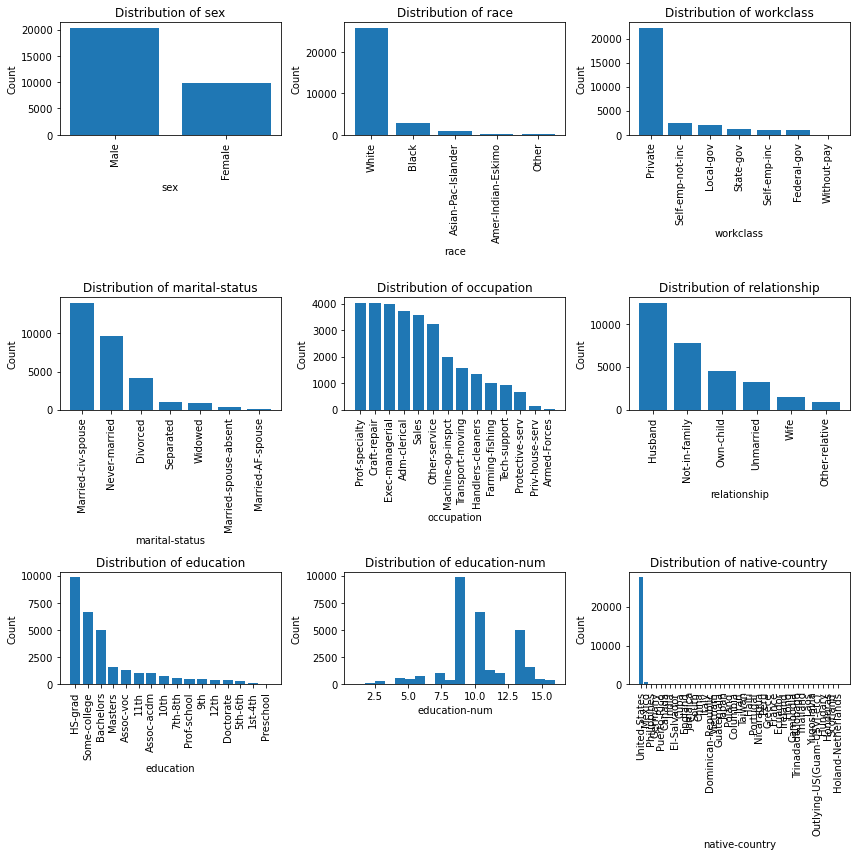

In [15]:
bar_charts = [
    'sex','race','workclass','marital-status','occupation',
    'relationship','education','education-num','native-country'
]

n = len(bar_charts)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(bar_charts):
    s = train_df[column]

    if pd.api.types.is_numeric_dtype(s):
        axes[i].hist(s.dropna(), bins=20)
    else:
        counts = s.value_counts(dropna=False)
        axes[i].bar(range(len(counts)), counts.values)
        axes[i].set_xticks(range(len(counts)))
        axes[i].set_xticklabels(counts.index.astype(str), rotation=90)

    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

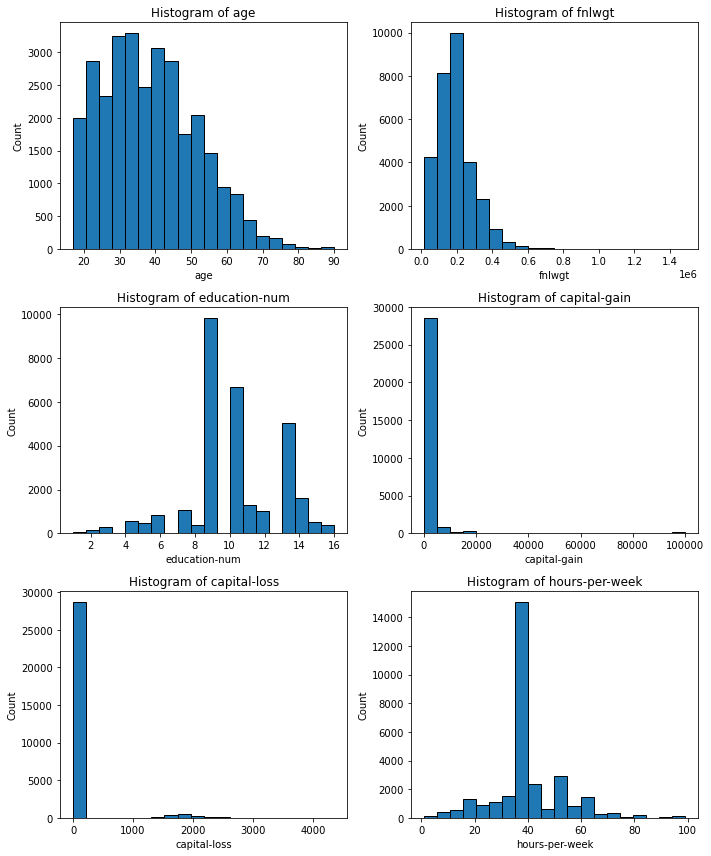

In [16]:
hist_charts = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
axes = axes.flatten()   
for i, column in enumerate(hist_charts):
    ax = axes[i]

    # Drop NA values for safety
    data = train_df[column].dropna()

    ax.hist(data, bins=20, edgecolor='black')
    
    ax.set_title(f"Histogram of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Count")

# Remove ANY unused subplot axes entirely
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Recategorize the Categorical features into more meaningful groups

In [17]:
workclass_mapping = {
    'State-gov':'Government',
    'Local-gov':'Government',
    'Federal-gov':'Government',
    'Self-emp-inc':'Entrepreneur',
    'Self-emp-not-inc':'Entrepreneur',
    'Without-pay':'Unemployed',
    'Never-worked':'Unemployed',
    'Private':'Private',
    np.nan:'Unknown'
}

# Apply mapping and insert into dataframe
train_df.insert(2,'workclass-cat',train_df['workclass'].map(workclass_mapping))

edu_mapping = {
    'Preschool':'HS-dropout',
    '1st-4th':'HS-dropout',
    '5th-6th':'HS-dropout',
    '7th-8th':'HS-dropout',
    '9th':'HS-dropout',
    '10th':'HS-dropout',
    '11th':'HS-dropout',
    '12th':'HS-dropout',
    'HS-grad':'HS-grad',
    'Some-college':'Some-college',
    'Assoc-acdm':'Some-college',
    'Assoc-voc':'Some-college',
    'Bachelors':'Bachelors',
    'Masters':'Advanced-degree',
    'Prof-school':'Advanced-degree',
    'Doctorate':'Advanced-degree',
    np.nan:'Unknown'
}

train_df.insert(4,"education-cat",train_df['education'].map(edu_mapping))

marital_mapping = {
    'Never-married':'Single/Unmarried',
    'Divorced':'Single/Unmarried',
    'Separated':'Single/Unmarried',
    'Widowed':'Single/Unmarried',
    'Married-spouse-absent':'Single/Unmarried',
    'Married-civ-spouse':'Married',
    'Married-AF-spouse':'Married',
    np.nan:'Unknown'
}

train_df.insert(7,'marital-cat',train_df['marital-status'].map(marital_mapping))

occupation_mapping = {
    'Exec-managerial':'White-collar',
    'Prof-specialty':'White-collar',
    'Tech-support':'White-collar',
    
    'Other-service':'Service',
    'Sales':'Service',
    'Adm-clerical':'Service',
    'Protective-serv':'Service',
    
    'Craft-repair':'Blue-collar',
    'Transport-moving':'Blue-collar',
    'Machine-op-inspct':'Blue-collar',

    'Armed-Forces':'Military',

    'Priv-house-serv':'Manual',
    'Farming-fishing':'Manual',
    'Handlers-cleaners':'Manual',

    np.nan:'Unknown'
}

train_df.insert(10,'occupation-cat',train_df['occupation'].map(occupation_mapping))

train_df.insert(18,'native_imm_cat',pd.Series(np.where(train_df['native-country'] == 'United-States', 'Native', 'Immigrant')))

# drop all adjusted categorical features in favor of their derived categories
train_df.drop(['workclass','fnlwgt','education','education-num','marital-status','occupation','native-country'], axis = 1, inplace = True)

In [18]:
train_df

,age,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native_imm_cat,pred
0,39,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,2174,0,40,Native,<=50K
1,50,Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,0,0,13,Native,<=50K
2,38,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,0,0,40,Native,<=50K
3,53,Private,HS-dropout,Married,Manual,Husband,Black,Male,0,0,40,Native,<=50K
4,28,Private,Bachelors,Married,White-collar,Wife,Black,Female,0,0,40,Immigrant,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Some-college,Married,White-collar,Wife,White,Female,0,0,38,NaN,<=50K
32557,40,Private,HS-grad,Married,Blue-collar,Husband,White,Male,0,0,40,NaN,>50K
32558,58,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,0,0,40,NaN,<=50K
32559,22,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,0,0,20,NaN,<=50K


## One Hot Encoding and Correlation Matrix

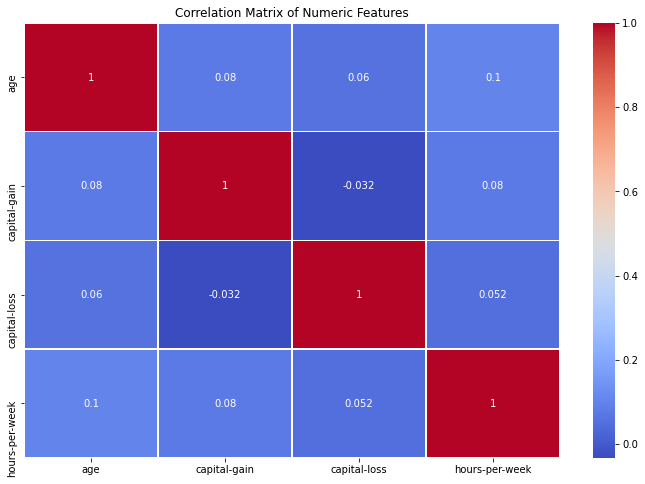

In [19]:
#OHE for numerical features only

# Select numeric columns only
numeric_df = train_df.select_dtypes(include=['int32', 'int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

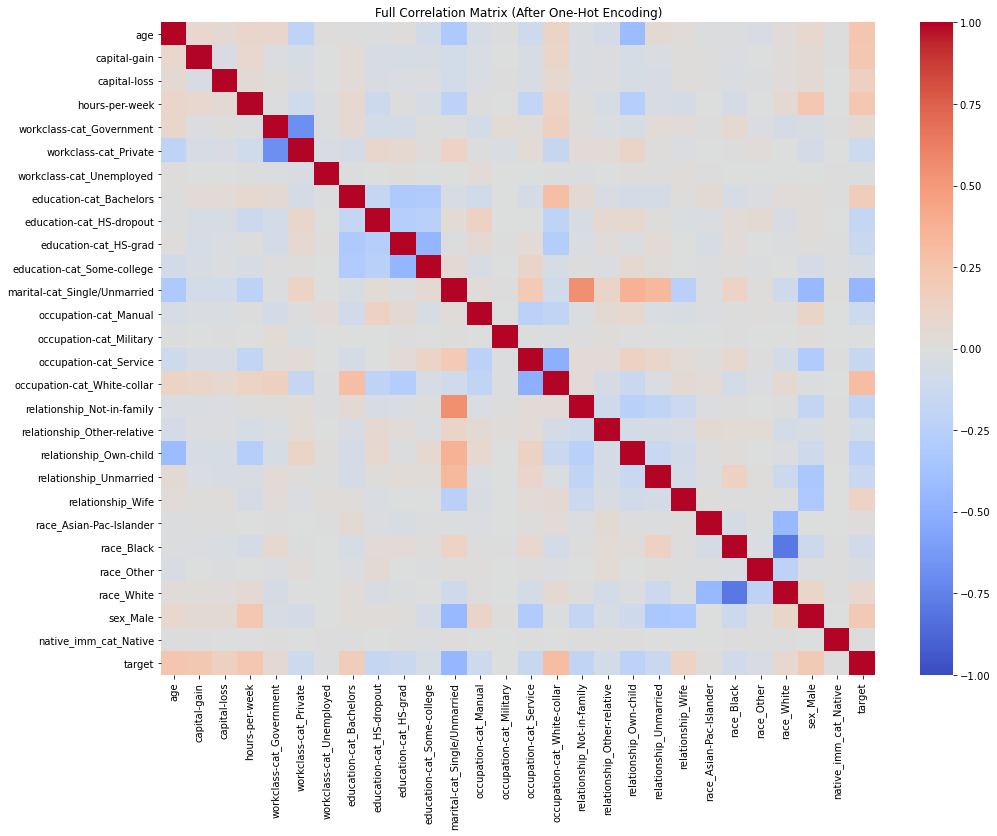

In [20]:
#OHE for correlation matrix

# One-hot encode categorical features
encoded_df = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)

# Add encoded label for correlation study
encoded_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

corr = encoded_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Full Correlation Matrix (After One-Hot Encoding)")
plt.show()

In [21]:
# Convert to pairs of correlations
corr_pairs = corr.unstack()

# Sort by absolute value, descending
corr_pairs_sorted = corr_pairs.abs().sort_values(ascending=False)
corr_pairs_sorted = corr_pairs_sorted[corr_pairs_sorted < 0.999]  

corr_pairs_sorted

race_White                    race_Black                    0.794852
race_Black                    race_White                    0.794852
workclass-cat_Private         workclass-cat_Government      0.684895
workclass-cat_Government      workclass-cat_Private         0.684895
marital-cat_Single/Unmarried  relationship_Not-in-family    0.547048
                                                              ...   
relationship_Unmarried        native_imm_cat_Native         0.000200
workclass-cat_Unemployed      race_White                    0.000162
race_White                    workclass-cat_Unemployed      0.000162
education-cat_Some-college    relationship_Wife             0.000037
relationship_Wife             education-cat_Some-college    0.000037
Length: 756, dtype: float64

In [22]:
# Convert pred to binary
train_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

# One-hot encode ALL features except target
encoded = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)

# Compute correlation with target only
corr_target = encoded.corr()['target'].sort_values(ascending=False)

corr_target

target                          1.000000
occupation-cat_White-collar     0.302302
age                             0.242017
hours-per-week                  0.229435
capital-gain                    0.221204
sex_Male                        0.216668
education-cat_Bachelors         0.178902
capital-loss                    0.150026
relationship_Wife               0.125092
race_White                      0.084781
workclass-cat_Government        0.054867
race_Asian-Pac-Islander         0.011465
native_imm_cat_Native           0.003721
occupation-cat_Military        -0.005513
workclass-cat_Unemployed       -0.012415
race_Other                     -0.032137
education-cat_Some-college     -0.050727
relationship_Other-relative    -0.084526
race_Black                     -0.088394
occupation-cat_Manual          -0.116737
workclass-cat_Private          -0.117137
education-cat_HS-grad          -0.136331
relationship_Unmarried         -0.145894
occupation-cat_Service         -0.153870
education-cat_HS

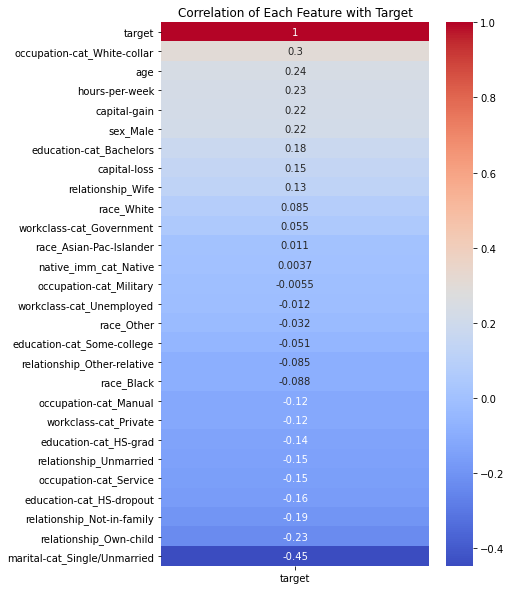

In [23]:
plt.figure(figsize=(6,10))
sns.heatmap(corr_target.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation of Each Feature with Target")
plt.show()

In [24]:
# Remove native-country
encoded_filtered = encoded.drop(columns=[col for col in encoded.columns 
                                         if col.startswith("native-country_")])

# Remove numeric columns
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                'capital-loss', 'hours-per-week', 'target']  
encoded_filtered = encoded_filtered.drop(columns=[col for col in numeric_cols 
                                                  if col in encoded_filtered.columns])

# Compute correlation with target only (SORTED DESCENDING)
corr_target_only = encoded_filtered.join(train_df['target']) \
                                   .corr()['target'] \
                                   .sort_values(ascending=False)


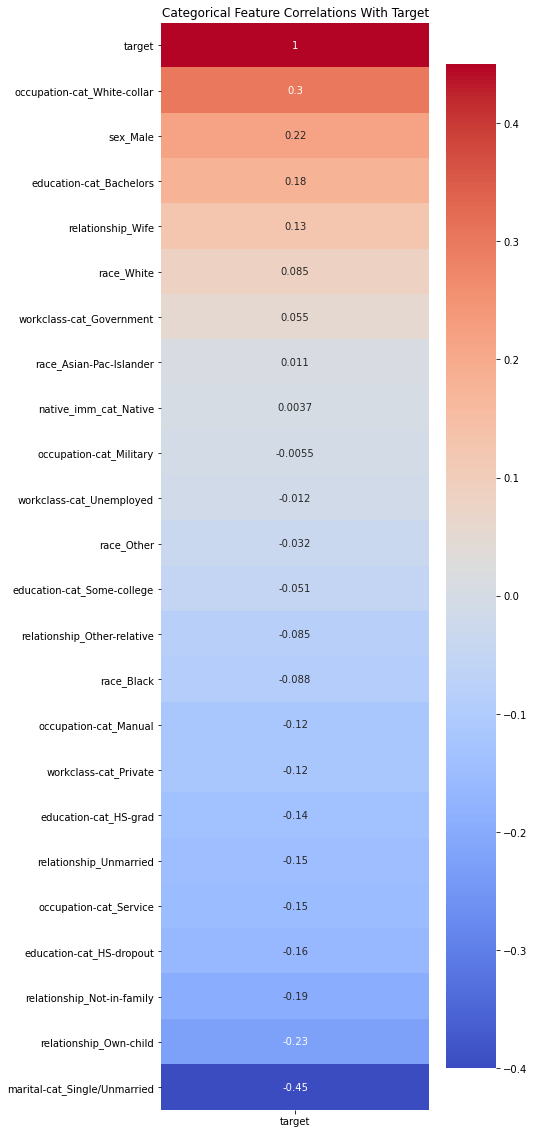

In [25]:
plt.figure(figsize=(6, 20))
sns.heatmap(corr_target_only.to_frame(),
            annot=True,
            cmap='coolwarm',
            vmin=-0.4,
            vmax=0.45)
plt.title("Categorical Feature Correlations With Target")
plt.show()

In [26]:
# Full correlation matrix among remaining categorical columns
cat_corr_matrix = encoded_filtered.corr()

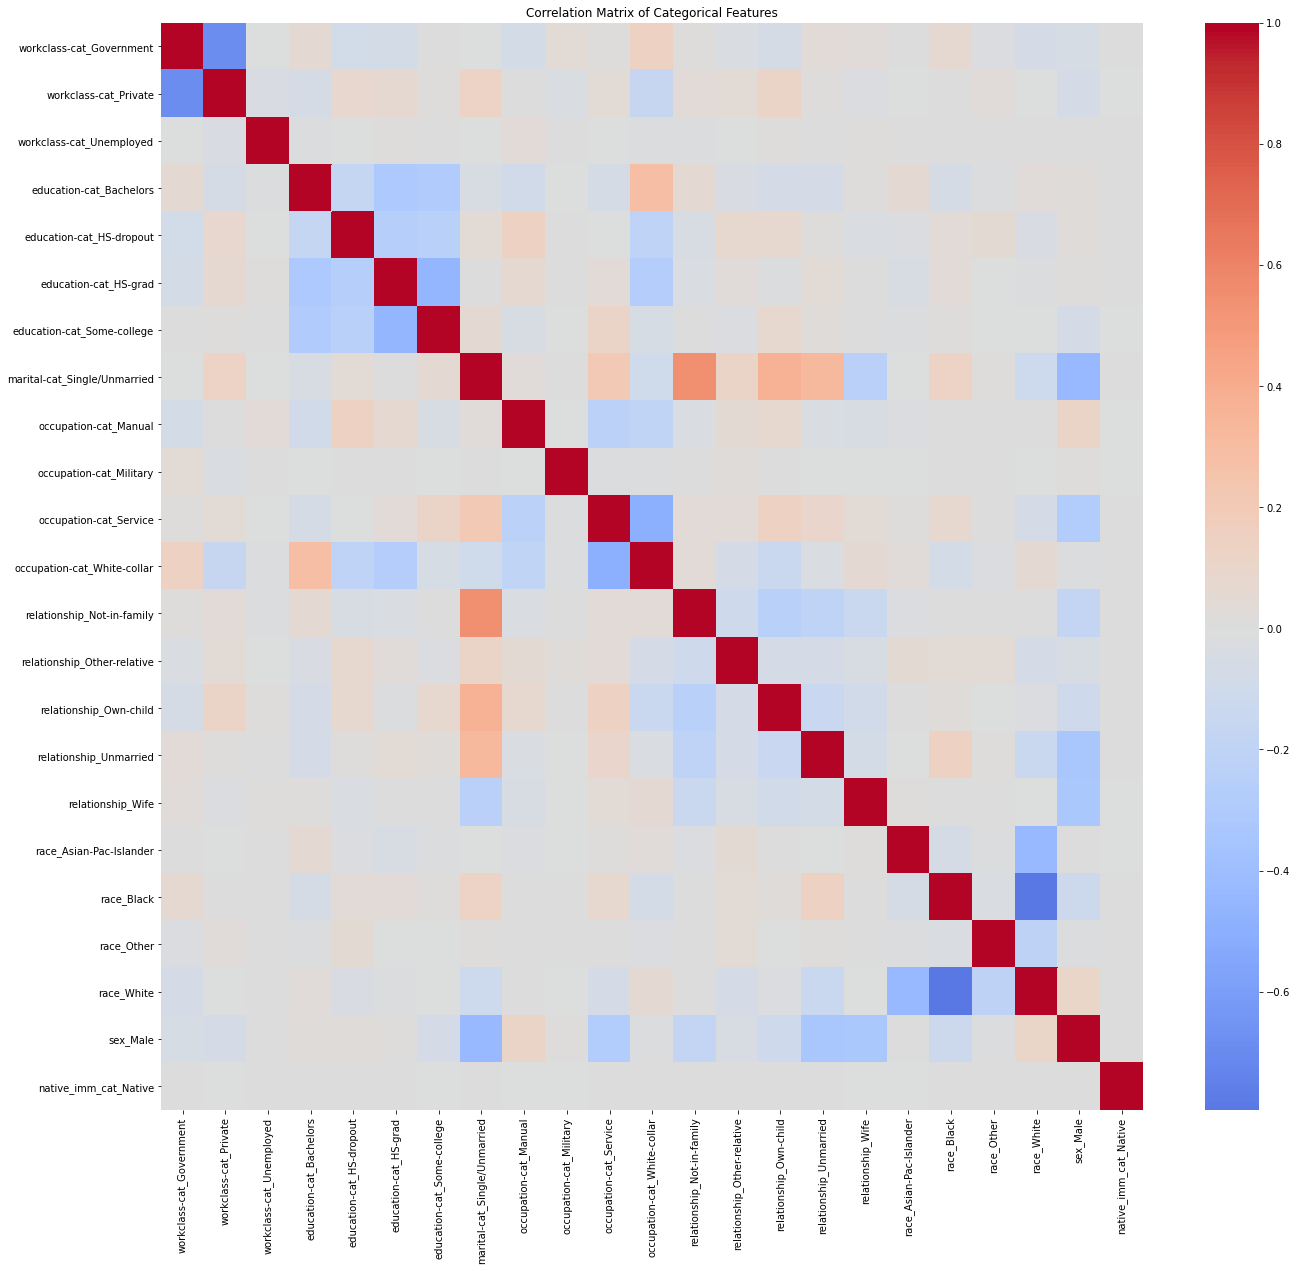

In [27]:
plt.figure(figsize=(22, 20))
sns.heatmap(cat_corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Categorical Features")
plt.show()

## Normalization --- Jieun's Part

capital-gain and capital-loss variables are extremely right-skewed with heavy zeros and a few large outliers. Standard normalization (like Min–Max or Z-score) will not work well.

In [28]:
#Log transformation (best for heavy right-skew)
eda_df = train_df.copy()

eda_df['capital_gain_log'] = np.log1p(eda_df['capital-gain'])
eda_df['capital_loss_log'] = np.log1p(eda_df['capital-loss'])

#log1p(x) handles zeros safely.
#Compresses extreme values.
#Spreads out dense low-value regions.

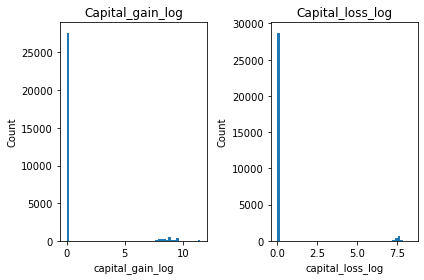

In [29]:
#capital gain
plt.subplot(1, 2, 1)
plt.hist(eda_df['capital_gain_log'], bins=50)
plt.title("Capital_gain_log")
plt.xlabel("capital_gain_log")
plt.ylabel("Count")

#capital loss
plt.subplot(1, 2, 2)
plt.hist(eda_df['capital_loss_log'], bins=50)
plt.title("Capital_loss_log")
plt.xlabel("capital_loss_log")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [30]:
#Binning


# capital-gain bins
gain_bins = [-1, 0, 5000, 15000, 30000, np.inf]
gain_labels = ['no_gain', 'low_gain', 'medium_gain', 'high_gain', 'very_high_gain']

eda_df['capital_gain_bin'] = pd.cut(
    eda_df['capital-gain'], 
    bins=gain_bins, 
    labels=gain_labels
)

# capital-loss bins
loss_bins = [-1, 0, 1000, 2000, np.inf]
loss_labels = ['no_loss', 'low_loss', 'medium_loss', 'high_loss']

eda_df['capital_loss_bin'] = pd.cut(
    eda_df['capital-loss'],
    bins=loss_bins,
    labels=loss_labels
)

print(eda_df['capital_gain_bin'].value_counts(), "\n\n")
print(eda_df['capital_loss_bin'].value_counts())

capital_gain_bin
no_gain           27601
medium_gain         984
low_gain            972
high_gain           429
very_high_gain      153
Name: count, dtype: int64 


capital_loss_bin
no_loss        28712
medium_loss     1098
high_loss        295
low_loss          34
Name: count, dtype: int64


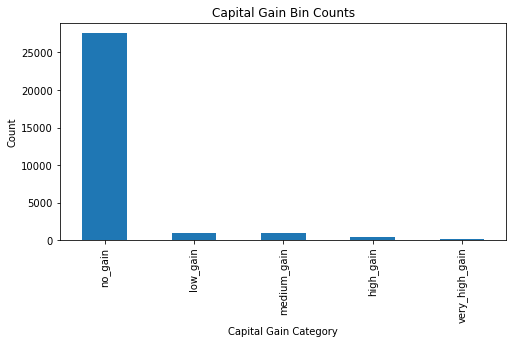

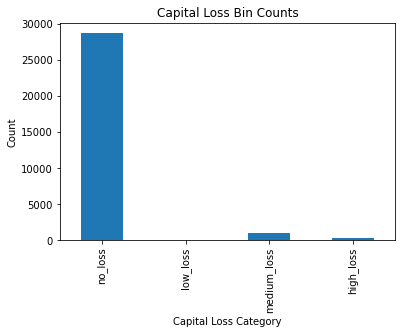

In [31]:
plt.figure(figsize=(8, 4))
eda_df['capital_gain_bin'].value_counts().sort_index().plot(kind='bar')
plt.title("Capital Gain Bin Counts")
plt.xlabel("Capital Gain Category")
plt.ylabel("Count")
plt.show()

eda_df['capital_loss_bin'].value_counts().sort_index().plot(kind='bar')
plt.title("Capital Loss Bin Counts")
plt.xlabel("Capital Loss Category")
plt.ylabel("Count")
plt.show()

In [32]:
#Binary Indicators
eda_df['has_capital_gain'] = (eda_df['capital-gain'] > 0).astype(int)
eda_df['has_capital_loss'] = (eda_df['capital-loss'] > 0).astype(int)

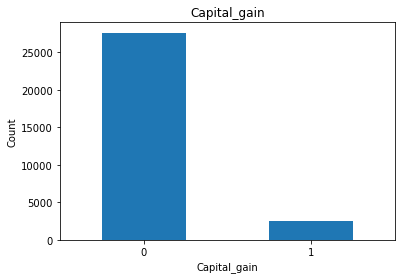

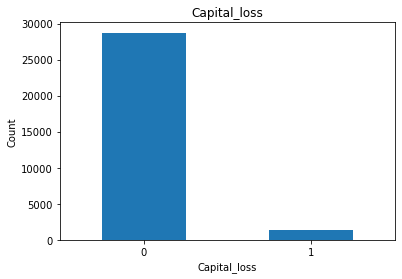

In [33]:
eda_df['has_capital_gain'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(6,4),
    rot=0
)
plt.title('Capital_gain')
plt.xlabel('Capital_gain')
plt.ylabel('Count')
plt.show()

eda_df['has_capital_loss'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(6,4),
    rot=0
)
plt.title('Capital_loss')
plt.xlabel('Capital_loss')
plt.ylabel('Count')
plt.show()

## Shelsy's Part

In [34]:
train_df

,age,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native_imm_cat,pred,target
0,39,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,2174,0,40,Native,<=50K,0
1,50,Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,0,0,13,Native,<=50K,0
2,38,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,0,0,40,Native,<=50K,0
3,53,Private,HS-dropout,Married,Manual,Husband,Black,Male,0,0,40,Native,<=50K,0
4,28,Private,Bachelors,Married,White-collar,Wife,Black,Female,0,0,40,Immigrant,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Some-college,Married,White-collar,Wife,White,Female,0,0,38,NaN,<=50K,0
32557,40,Private,HS-grad,Married,Blue-collar,Husband,White,Male,0,0,40,NaN,>50K,1
32558,58,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,0,0,40,NaN,<=50K,0
32559,22,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,0,0,20,NaN,<=50K,0


In [35]:
#undersampling
X_train = train_df.drop ('pred', axis=1)
Y_train = train_df['pred']

under= RandomUnderSampler(random_state=42)
X_under, Y_under = under.fit_resample(X_train, Y_train)

print ('before:' , Y_train.value_counts())
print ('after:' , Y_under.value_counts())

before: pred
<=50K    22633
>50K      7506
Name: count, dtype: int64
after: pred
<=50K    7506
>50K     7506
Name: count, dtype: int64


In [36]:
#oversampling
over = RandomOverSampler(random_state=42)
X_over, Y_over = over.fit_resample(X_train, Y_train)
print ('before:' , Y_train.value_counts())
print ('after:' , Y_over.value_counts())

before: pred
<=50K    22633
>50K      7506
Name: count, dtype: int64
after: pred
<=50K    22633
>50K     22633
Name: count, dtype: int64
